In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, concatenate, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np
from PIL import Image

import os
import sys
import glob
import shutil

Using TensorFlow backend.


In [2]:
def find_corresponding_images(masks_dir, input_images_dir, input_ext='.bmp'):
    if not os.path.exists(masks_dir) or not os.path.isdir(masks_dir):
        raise ValueError('The path for the masks directory %s does not exist or is not a folder' % masks_dir)
    if not os.path.exists(input_images_dir) or not os.path.isdir(input_images_dir):
        raise ValueError('The path for the input images directory %s does not exist or is not a folder' % input_images_dir)

    # find the segmentation masks (bmp) images in the masks directory
    mask_files = glob.glob(os.path.join(masks_dir, "*.bmp"))
    print('Found %d segmentation masks ' % len(mask_files))

    num_images = len(mask_files)

    image_tuples = []
    for idx, mask_path in enumerate(mask_files):
        basename = os.path.basename(mask_path)
        sys.stdout.write('\r>> Searching image for  segmentation mask %s (%d/%d) ' % (basename, idx+1, num_images))
        sys.stdout.flush()
        img_path = os.path.join(input_images_dir, basename.replace('.bmp', input_ext))
        if os.path.exists(img_path):
            image_tuples.append((img_path, mask_path))
        else:
            sys.stdout.write('\r>> Error! Could not find input image for segmentation %s' % basename)
            sys.stdout.flush()

    return image_tuples

In [3]:
image_tuples = sorted(find_corresponding_images('FASSEG/train/Train_RGB', 'FASSEG/train/Train_Labels_coarse'))
image_tuples2 = sorted(find_corresponding_images('FASSEG/train/Train_RGB', 'FASSEG/train/Train_Labels_fine'))


data = []
label_coarse = []
label_fine = []

new_width = 256
new_height = 256

for i in range(len(image_tuples)):
    #x = Image.open(image_tuples[i][1]).convert('L')
    #y = Image.open(image_tuples[i][0]).convert('L')
    #z = Image.open(image_tuples2[i][0]).convert('L')
    x = Image.open(image_tuples[i][1])
    y = Image.open(image_tuples[i][0])
    z = Image.open(image_tuples2[i][0])
    
    width, height = x.size   

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    x = x.crop((left, top, right, bottom))

    width, height = y.size   

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    y = y.crop((left, top, right, bottom))
    
    width, height = z.size   

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    z = z.crop((left, top, right, bottom))
    
    data.append(np.array(x))
    label_coarse.append(np.array(y))
    label_fine.append(np.array(z))

Found 20 segmentation masks 
>> Searching image for  segmentation mask 17.bmp (20/20) Found 20 segmentation masks 
>> Searching image for  segmentation mask 17.bmp (20/20) 

In [4]:
C_train = np.array(data)
X_train = np.array(label_coarse)
y_train = np.array(label_fine)

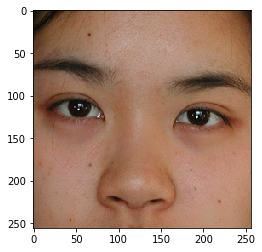

In [5]:
plt.imshow(C_train[0])

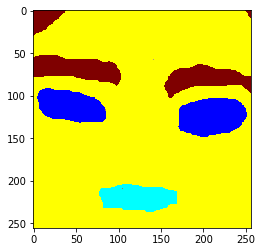

In [6]:
plt.imshow(X_train[0])

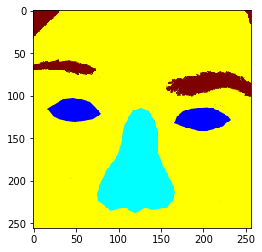

In [7]:
plt.imshow(y_train[0])

In [8]:
print('input, condition and ground truth shape are {},{} and {}, resp.'.format(X_train.shape,C_train.shape,y_train.shape))

input, condition and ground truth shape are (20, 256, 256, 3),(20, 256, 256, 3) and (20, 256, 256, 3), resp.


In [9]:
class CGAN():
    def __init__(self):
        # Input shape 
        self.img_rows = 256
        self.img_cols = 256
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=self.img_shape)
        label = Input(shape=self.img_shape)
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(32, input_dim=2*np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()
        
        noise = Input(shape=self.img_shape)
        label = Input(shape=self.img_shape)
        
        noise_embedding = Flatten()(noise)
        label_embedding = Flatten()(label)

        model_input = concatenate([noise_embedding, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(32, input_dim=2*np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=self.img_shape)

        label_embedding = Flatten()(label)
        flat_img = Flatten()(img)

        model_input = concatenate([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)

    def train(self, epochs, batch_size=10, sample_interval=50):

        ########### Load the dataset ########## 
        X_train = np.array(label_fine)
        y_train = np.array(data)
        noise_train = np.array(label_coarse)
        
        ########### Configure input ##########
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        y_train = (y_train.astype(np.float32) - 127.5) / 127.5
        noise_train = (noise_train.astype(np.float32) - 127.5) / 127.5
        #X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, condition = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = noise_train[idx]

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, condition])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, condition], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, condition], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            #sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, condition], valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.array(label_coarse)[10:20]
        condition = np.array(data)[10:20]
        
        noise = (noise.astype(np.float32) - 127.5) / 127.5
        condition = (condition.astype(np.float32) - 127.5) / 127.5

        gen_imgs = self.generator.predict([noise, condition])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[5*i+j])
                axs[i,j].set_title("Picture: {}".format(5*i+j+1))
                axs[i,j].axis('off')
        fig.savefig("images_FASSEG/%d.png" % epoch)
        plt.close()

In [10]:
if __name__ == '__main__':
    cgan = CGAN()
    cgan.train(epochs=10000, batch_size=10, sample_interval=20)

W0907 10:43:06.254021 140735511479168 deprecation_wrapper.py:119] From /anaconda3/envs/AML_Sarcasm/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0907 10:43:06.255685 140735511479168 deprecation_wrapper.py:119] From /anaconda3/envs/AML_Sarcasm/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0907 10:43:06.259413 140735511479168 deprecation_wrapper.py:119] From /anaconda3/envs/AML_Sarcasm/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0907 10:43:06.282232 140735511479168 deprecation_wrapper.py:119] From /anaconda3/envs/AML_Sarcasm/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                12582944  
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               16896     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
__________

/anaconda3/envs/AML_Sarcasm/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
W0907 10:43:14.983941 140735511479168 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0907 10:43:14.990606 140735511479168 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0907 10:43:14.993788 140735511479168 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0907 10:43:14.997056 140735511479168 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0907 10:43:15.000391 140735511479168 image.py

0 [D loss: 1.822710, acc.: 50.00%] [G loss: 1.237707]


W0907 10:43:15.003868 140735511479168 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0907 10:43:15.006706 140735511479168 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0907 10:43:15.009724 140735511479168 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0907 10:43:15.012910 140735511479168 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0907 10:43:15.015994 140735511479168 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/anaconda3/envs/AML_Sarcasm/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.t

1 [D loss: 2.169780, acc.: 55.00%] [G loss: 0.734329]
2 [D loss: 1.562343, acc.: 75.00%] [G loss: 3.555965]
3 [D loss: 0.176202, acc.: 95.00%] [G loss: 5.856462]
4 [D loss: 0.511213, acc.: 90.00%] [G loss: 3.550937]
5 [D loss: 2.277297, acc.: 75.00%] [G loss: 2.366270]
6 [D loss: 2.519920, acc.: 65.00%] [G loss: 2.926683]
7 [D loss: 0.412392, acc.: 95.00%] [G loss: 7.778089]
8 [D loss: 0.490071, acc.: 85.00%] [G loss: 6.620755]
9 [D loss: 0.659139, acc.: 90.00%] [G loss: 8.120084]
10 [D loss: 1.690568, acc.: 85.00%] [G loss: 5.729616]
11 [D loss: 0.984473, acc.: 80.00%] [G loss: 11.145537]
12 [D loss: 0.016662, acc.: 100.00%] [G loss: 11.392828]
13 [D loss: 0.252913, acc.: 90.00%] [G loss: 13.847415]
14 [D loss: 0.002475, acc.: 100.00%] [G loss: 14.558879]
15 [D loss: 0.000002, acc.: 100.00%] [G loss: 12.835612]
16 [D loss: 0.024637, acc.: 100.00%] [G loss: 13.048633]
17 [D loss: 0.041635, acc.: 95.00%] [G loss: 13.130818]
18 [D loss: 0.217770, acc.: 95.00%] [G loss: 12.967740]
19 [D l

KeyboardInterrupt: 

(10, 256, 256, 3)


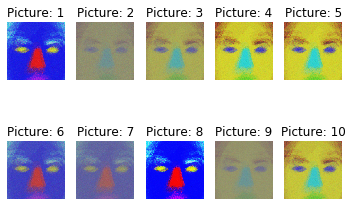

In [16]:
r, c = 2, 5
noise = np.array(label_coarse)[5:15]
condition = np.array(data)[5:15]
        
noise = (noise.astype(np.float32) - 127.5) / 127.5
condition = (condition.astype(np.float32) - 127.5) / 127.5

pic = cgan.generator.predict([noise, condition])
#pic = np.array(label_coarse)[10:20]
#pic = np.array(data)[10:20]
print(pic.shape)
pic = 0.5 * pic + 0.5
fig, axs = plt.subplots(r, c)
for i in range(r):
    for j in range(c):
        axs[i,j].imshow(pic[5*i+j])
        axs[i,j].set_title("Picture: {}".format(5*i+j+1))
        axs[i,j].axis('off')
plt.show()
#fig.savefig("images_FASSEG/%d.png" % epoch)
#plt.close()